### Solve cavity flow governed by Navier-Stokes equation. using PINNs (Under simple setting)
Goal : using PINNs, predicts $(\psi, p)$ for the input $(x,y)$


Classical Navier-Stokes equation in 2D, Incompressible Navier-Stokes equations with constant viscosity (ignore external force)
\begin{gather}
\boldsymbol{u}_t + (\boldsymbol{u} \cdot \nabla)\boldsymbol{u} + \nabla \boldsymbol{p}/\rho - \nu \nabla^2 \boldsymbol{u}\\
\nabla \cdot \boldsymbol{u} = 0, \quad \text{where} \quad \boldsymbol{u}\equiv(u,v)
\end{gather}
If steady state $u_t = 0$
\begin{align}
u_x + v_y &= 0\\
u u_x + v u_y + p_x/\rho - \nu(u_{xx} + u_{yy}) &= 0\\
u v_x + v v_y + p_y/\rho - \nu(v_{xx} + v_{yy}) &= 0\\
\end{align}
boundary condition

$\{x,y\} \in \{0,1\}\times\{0,1\}$

$(u,v)=(1,0)$ for $y=0$ and $(u,v)=(0,0)$ for other boundaries.

For simplify, define stream function $ (u, v) = (\psi_y, -\psi_x)$

In [10]:
# YOUR CODE HERE (30pts)

import jax
from jax import numpy as jnp
import equinox as eqx
import optax
from jaxtyping import Array, Float, Int, PyTree

import numpy as np
import matplotlib.pyplot as plt

import tqdm

In [11]:
SEED = 5678
key = jax.random.PRNGKey(SEED)
rho = 1.0
nu = 0.4

xrange = [0, 1]
trange = [0, 1]

In [12]:
def dataset_gen(n_slices=20):
    x = jnp.linspace(xrange[0], xrange[1], n_slices + 1)
    y = jnp.linspace(trange[0], trange[1], n_slices + 1)
    x_col, y_col = jnp.meshgrid(x, y, indexing='ij')
    
    x_bc_down = x_col[:, 0]
    y_bc_down = y_col[:, 0]
    u_bc_down = jnp.ones_like(x_bc_down)
    v_bc_down = jnp.zeros_like(x_bc_down)
    
    x_bc_up = x_col[:, -1]
    y_bc_up = y_col[:, -1]
    u_bc_up = jnp.zeros_like(x_bc_down)
    v_bc_up = jnp.zeros_like(x_bc_down)
    
    x_bc_left = x_col[0, :]
    y_bc_left = y_col[0, :]
    u_bc_left = jnp.zeros_like(x_bc_down)
    v_bc_left = jnp.zeros_like(x_bc_down)
    
    x_bc_right = x_col[-1, :]
    y_bc_right = y_col[-1, :]
    u_bc_right = jnp.zeros_like(x_bc_down)
    v_bc_right = jnp.zeros_like(x_bc_down)
    
    x_bc = jnp.concatenate([x_bc_down, x_bc_up, x_bc_left, x_bc_right])
    y_bc = jnp.concatenate([y_bc_down, y_bc_up, y_bc_left, y_bc_right])
    u_bc = jnp.concatenate([u_bc_down, u_bc_up, u_bc_left, u_bc_right])
    v_bc = jnp.concatenate([v_bc_down, v_bc_up, v_bc_left, v_bc_right])
     
    x_col = x_col.flatten()
    y_col = y_col.flatten()
    
    return x_col, y_col, x_bc, y_bc, u_bc, v_bc

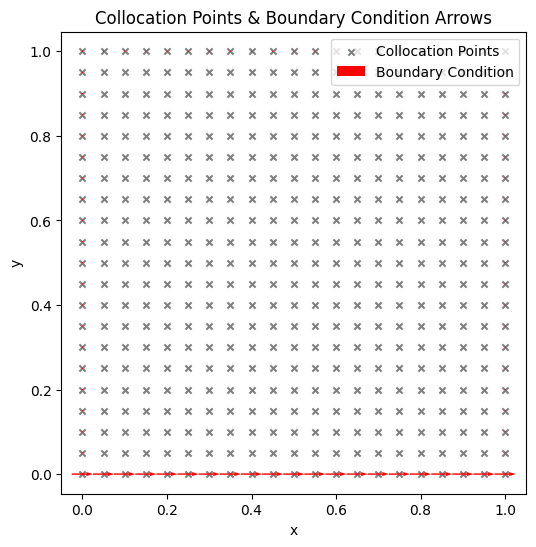

In [13]:
x_col, y_col, x_bc, y_bc, u_bc, v_bc = dataset_gen(n_slices=20)

plt.figure(figsize=(6,6))
plt.scatter(x_col, y_col,
            marker='x', s=20, color='gray',
            label='Collocation Points')

plt.quiver(
    x_bc, y_bc,
    u_bc, v_bc,
    angles='xy', scale_units='xy', scale=20,
    width=0.003, headwidth=3, headlength=5,
    pivot='mid',
    color='red', label='Boundary Condition'
)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Collocation Points & Boundary Condition Arrows')
plt.axis('equal')
plt.legend()
plt.show()


In [ ]:
# YOUR CODE HERE (30pts)

# YOUR NEURAL NETWORK DESIGN AND LOSS WITH RESIDUAL CODE HERE

class PINN(eqx.Module):
    mlp: eqx.nn.MLP
    
    def __init__(self, key):
        hidden_depth = 5
        hidden_width = 48
        
        self.mlp = eqx.nn.MLP(
            in_size=2,
            out_size=2,
            width_size=hidden_width,
            depth=hidden_depth,
            activation=jax.nn.swish,
            key=key
        )
    
    def __call__(self, x, y):
        psi, p = self.mlp(jnp.array([x, y]))
        return psi, p


\begin{gather}
    u = \psi_y,\quad v = -\psi_x \\
    u_x = \psi_{yx},\quad u_y = \psi_{yy},\quad v_x = -\psi_{xx},\quad v_y = -\psi_{xy} \\
    u_x = \psi_{yxx},\quad u_y = \psi_{yyy},\quad v_x = -\psi_{xxx},\quad v_y = -\psi_{xyy} \\
\end{gather}

prediction $u$ and $v$:
\begin{gather}
    u^{(\text{model})} = \psi^{(\text{model})}_y(x, y),\quad v^{(\text{model})} = -\psi^{(\text{model})}_x(x, y)
\end{gather}

Residual for boundary condition:
\begin{equation}
    L_\text{BC}(x, y) = \left(u^{(\text{model})} - u^{(\text{BC})}\right)^2 + \left(v^{(\text{model})} - v^{(\text{BC})}\right)^2
\end{equation}

Residual for differential equation:
\begin{align}
    L_\text{PDE}(x, y) 
    &= \left(u^{(\text{model})} u^{(\text{model})}_x + v^{(\text{model})} u^{(\text{model})}_y + p^{(\text{model})}_x/\rho - \nu(u^{(\text{model})}_{xx} + u^{(\text{model})}_{yy})\right)^2\\
    &+ \left(u^{(\text{model})} v^{(\text{model})}_x + v^{(\text{model})} v^{(\text{model})}_y + p^{(\text{model})}_y/\rho - \nu(v^{(\text{model})}_{xx} + v^{(\text{model})}_{yy})\right)^2
\end{align}

In [15]:
def residual_bc(model, x, y, u_bc, v_bc):
    grad_psi_p = jax.jacobian(
        model, 
        argnums=(0, 1), 
        has_aux=True
    ) # differentiate the psi to get u = psi_y, v = -psi_x.
    (psi_x, psi_y), p = grad_psi_p(x, y)
    u_pred = psi_y
    v_pred = -psi_x
    
    res_bc = (u_pred - u_bc) ** 2 + (v_pred - v_bc) ** 2
    return res_bc

def residual_pde(model, x, y):
    def psi_func(x, y):
        return model(x, y)[0]
    
    def p_func(x, y):
        return model(x, y)[1]
    
    grad_p = jax.grad(
        p_func, 
        argnums=(0, 1)
    ) # (x, y) => (p_x, p_y)
    
    first = jax.jacobian(
        psi_func, 
        argnums=(0, 1)
    ) # (x, y) => (psi_x, psi_y)
    
    second = jax.jacobian(
        first, 
        argnums=(0, 1)
    ) # (x, y) => ((psi_xx, psi_xy), (psi_yx, psi_yy))
    
    third = jax.jacobian(
        second, 
        argnums=(0, 1)
    ) # (x, y) => (((psi_xxx, psi_xxy), (psi_xyx, psi_xyy)), ((psi_yxx, psi_yxy), (psi_yyx, psi_yyy)))
    
    p_x, p_y= grad_p(x, y)
    
    psi_x, psi_y = first(x, y)
    (psi_xx, psi_xy), (psi_yx, psi_yy) = second(x, y)
    ((psi_xxx, _), (_, psi_xyy)), ((psi_yxx, _), (_, psi_yyy)) = third(x, y)
    
    u = psi_y
    v = -psi_x
    
    u_x = psi_yx
    u_y = psi_yy
    v_x = -psi_xx
    v_y = -psi_xy
    
    u_xx = psi_xxx
    u_yy = psi_xyy
    v_xx = -psi_yxx
    v_yy = -psi_yyy
    
    res_pde = (u * u_x + v * u_y + p_x / rho - nu * (u_xx + u_yy)) ** 2 \
            + (u * v_x + v * v_y + p_y / rho - nu * (v_xx + v_yy)) ** 2
    return res_pde

def loss_fn(model, dataset):
    x_col, y_col, x_bc, y_bc, u_bc, v_bc = dataset
    res_bc  = jax.vmap(residual_bc,  (None, 0, 0, 0, 0), 0)(model, x_bc, y_bc, u_bc, v_bc)
    res_pde = jax.vmap(residual_pde, (None, 0, 0),       0)(model, x_col, y_col)
    return jnp.mean(res_bc) + jnp.mean(res_pde)
    

In [16]:
# YOUR CODE HERE (30pts)

def train(
    model: PINN,
    dataset: tuple,
    optim: optax.GradientTransformation,
    steps: int,
):
    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    
    @eqx.filter_jit
    def make_step(
        model: PINN,
        opt_state: PyTree,
        dataset: tuple,
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss_fn)(model, dataset)
        updates, opt_state = optim.update(
            grads, opt_state, eqx.filter(model, eqx.is_array)
        )
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
    
    pbar = tqdm.trange(steps, desc="training", unit="step")
    for step in pbar:
        model, opt_state, loss_value = make_step(model, opt_state, dataset)
        pbar.set_postfix(loss=float(loss_value))
            
    return model


In [17]:
key, subkey = jax.random.split(key, 2)
model = PINN(subkey)

dataset = dataset_gen(n_slices=20)

# Example loss
loss_val, grads = eqx.filter_value_and_grad(loss_fn)(model, dataset)
print("loss:", loss_val)

# Example inference
output = model(0.5, 0.5)
print(output)

loss: 0.2503837
(Array(0.06298281, dtype=float32), Array(-0.04169174, dtype=float32))


In [ ]:
# hyperparameters
n_epochs = 20000
schedule = optax.piecewise_constant_schedule(
    init_value=1e-3,
    boundaries_and_scales={1000: 0.5, 5000: 0.5, 10000: 0.5}
)
optim = optax.adamw(schedule)

model = train(model, dataset, optim, n_epochs)

training:  43%|████▎     | 8658/20000 [03:28<04:12, 44.88step/s, loss=0.0243]

In [ ]:
# VISUALIZATION (10pts)

# YOUR VISUALIZATION CODE HERE

